In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('..')
from src.ham_to_sparse_matrix import *
from src.constants import *
from src.matrix_to_ps import matrix_to_pauli_strings
from src.binary_encodings import *

import sympy as sp
import sys
import scipy.sparse.linalg

from src.qiskit_utilities import *
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes

from qiskit import qpy
from src.timer import *

import pickle

from qiskit import QuantumCircuit, transpile


backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

In [3]:
bosonNI=sp.expand( pn**2/(2*aLat) + (aLat/2)*((qnP1-qnM1)/(2*aLat))**2 )
bosonI=sp.expand( (aLat/2)*V(qn)**2 + aLat*V(qn)*(qnP1-qnM1)/(4*aLat) + aLat*(qnP1-qnM1)*V(qn)/(4*aLat) )
fermionNI=sp.expand( -(xdnP1*xn+xdn*xnP1)/(2*aLat) )
fermionI=sp.expand( sp.diff(V(qn),qn)*(xdn*xn-(1/2)) )

N=2
aVal=1

# depends on finite-difference method
qs=[SiteSymbol('q',str(i)) for i in range(-1,N+1,1)]
# maybe make qs a normal site list
# and make an extra boundaryQs list for q[-1], q[N]
# counting would be normal computer science way for rest of code.

ps=[SiteSymbol('p',str(i)) for i in range(-1,N+1,1)] # don't really need extras
aops=[SiteSymbol('a',str(i)) for i in range(-1,N+1,1)]
adags=[SiteSymbol('a^{\dagger}',str(i)) for i in range(-1,N+1,1)]
xs=[SiteSymbol('\chi',str(i)) for i in range(-1,N+1,1)]
xdags=[SiteSymbol('\chi^{\dagger}',str(i)) for i in range(-1,N+1,1)]

# note this is exactly hardcoded for this finite difference method.
bcType = 'dirichlet'
boundaryConditions = {}
if bcType == 'periodic':
    boundaryConditions = {qs[0]: qs[N], qs[N+1]: qs[1],
                          xs[0]: -xs[N], xs[N+1]: -xs[1], 
                          xdags[0]: -xdags[N],  xdags[N+1]: -xdags[1]
                         }
    
elif bcType == 'dirichlet':
    boundaryConditions = { qs[0]: 0, qs[N+1]: 0,
                          xs[0]: 0, xs[N+1]: 0,
                          xdags[0]: 0, xdags[N+1]:0
                         }

## CM -0.2

In [18]:
ham=0

mass=1
c=-0.2
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

1/25 - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + 77541356*a^{\dagger}_{0}/99690943 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 + 17*a^{\dagger}_{0}*a_{0}/80 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - 23*a^{\dagger}_{0}**2/80 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{1}/45239074 + a^{\dagger}_{0}**3*a_{0}/8 + a^{\dagger}_{0}**4/8 - 77541356*a^{\dagger}_{1}/99690943 + 131836323*a^{\dagger}_{1}

In [8]:
for cutoff in [2,3,4,5,6,7,8]:
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]

    ps=matrix_to_pauli_strings(hamMat,standard_encode)
    op = pauli_string_to_op(ps)
    with open("Data/op_quad_cm0p2_lambda{}.pickle".format(cutoff), "wb") as f:
        pickle.dump(op, f)

    nq=math.floor(math.log2(hamMat.shape[0]))
    if not math.log2(hamMat.shape[0]).is_integer():
        nq+=1

    ansatz = RealAmplitudes(nq, reps=cutoff)

    
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
    results=[]
    for i in range(10):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)

    print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))
    
    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))

--------- Lambda =  2  ----------
2 & -4.87e-01 & -9.11e-01 \\
gates for one trotter step =  14
--------- Lambda =  3  ----------
3 & 1.64e-03 & -1.03e+00 \\
gates for one trotter step =  6492
--------- Lambda =  4  ----------
4 & 1.82e-01 & 2.19e-01 \\
gates for one trotter step =  754
--------- Lambda =  5  ----------
5 & -1.11e-01 & 1.85e-03 \\
gates for one trotter step =  25174
--------- Lambda =  6  ----------
6 & -1.74e-02 & 3.51e-03 \\
gates for one trotter step =  49564
--------- Lambda =  7  ----------
7 & 1.69e-01 & 4.36e-02 \\
gates for one trotter step =  71458
--------- Lambda =  8  ----------
8 & 1.31e-01 & 1.70e+00 \\
gates for one trotter step =  7822


In [19]:
cutoff=16
print("--------- Lambda = ", cutoff, " ----------")
hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]

ps=matrix_to_pauli_strings(hamMat,standard_encode)
op = pauli_string_to_op(ps)
with open("Data/op_quad_cm0p2_lambda{}.pickle".format(cutoff), "wb") as f:
    pickle.dump(op, f)

nq=math.floor(math.log2(hamMat.shape[0]))
if not math.log2(hamMat.shape[0]).is_integer():
    nq+=1

ansatz = RealAmplitudes(nq, reps=cutoff)


vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
results=[]
for i in range(10):
    results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)

print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))

qc = QuantumCircuit(nq,nq)
qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
print("gates for one trotter step = ", tmp.count_ops().get('cx'))

--------- Lambda =  16  ----------


: 

: 

In [9]:
for cutoff in [2,4,6,8,10,12,14,16]:
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)

--------- Lambda =  2  ----------
-0.4870819
--------- Lambda =  4  ----------
0.18196265
--------- Lambda =  6  ----------
-0.017404668
--------- Lambda =  8  ----------
0.13103375
--------- Lambda =  10  ----------
0.19107112
--------- Lambda =  12  ----------
0.19515413
--------- Lambda =  14  ----------
0.19457427
--------- Lambda =  16  ----------
0.19468053


## CM -0.4

In [6]:
ham=0

mass=1
c=-0.4
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

4/25 - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + 70053979*a^{\dagger}_{0}/82559406 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 + 9*a^{\dagger}_{0}*a_{0}/80 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - 31*a^{\dagger}_{0}**2/80 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{1}/45239074 + a^{\dagger}_{0}**3*a_{0}/8 + a^{\dagger}_{0}**4/8 - 70053979*a^{\dagger}_{1}/82559406 + 131836323*a^{\dagger}_{1}*

In [7]:
for cutoff in [2,4,6,8,10,12,14,16]:
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)

--------- Lambda =  2  ----------
0.06428951
--------- Lambda =  4  ----------
-0.15353835
--------- Lambda =  6  ----------
-0.22874655
--------- Lambda =  8  ----------
0.038857713
--------- Lambda =  10  ----------
0.09883384
--------- Lambda =  12  ----------
0.10344948
--------- Lambda =  14  ----------
0.10074462
--------- Lambda =  16  ----------
0.10215589


## C = -0.1

In [8]:
ham=0

mass=1
c=-0.1
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

1/100 - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + 23168379*a^{\dagger}_{0}/31204796 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 + 21*a^{\dagger}_{0}*a_{0}/80 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - 19*a^{\dagger}_{0}**2/80 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{1}/45239074 + a^{\dagger}_{0}**3*a_{0}/8 + a^{\dagger}_{0}**4/8 - 23168379*a^{\dagger}_{1}/31204796 + 131836323*a^{\dagger}_{1

In [19]:
for cutoff in range(2,18,2):
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)

--------- Lambda =  2  ----------
-0.7150041
--------- Lambda =  4  ----------
0.21914008
--------- Lambda =  6  ----------
0.10237059
--------- Lambda =  8  ----------
0.19822235
--------- Lambda =  10  ----------
0.2547775
--------- Lambda =  12  ----------
0.25834623
--------- Lambda =  14  ----------
0.25848448
--------- Lambda =  16  ----------
0.25823307


## C=-0.8

In [5]:
ham=0

mass=1
c=-0.8
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

16/25 - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + 7722793*a^{\dagger}_{0}/7801199 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 - 7*a^{\dagger}_{0}*a_{0}/80 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - 47*a^{\dagger}_{0}**2/80 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{1}/45239074 + a^{\dagger}_{0}**3*a_{0}/8 + a^{\dagger}_{0}**4/8 - 7722793*a^{\dagger}_{1}/7801199 + 131836323*a^{\dagger}_{1}*\ch

In [6]:
e0raw0p8=[]
for cutoff in range(2,18,2):
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)
    e0raw0p8.append(np.min(ens).real)

--------- Lambda =  2  ----------
-0.48708177
--------- Lambda =  4  ----------
0.12766445
--------- Lambda =  6  ----------
-0.49799758
--------- Lambda =  8  ----------
-0.017360238
--------- Lambda =  10  ----------
0.021319462
--------- Lambda =  12  ----------
0.006229443
--------- Lambda =  14  ----------
0.013883656
--------- Lambda =  16  ----------
0.019356793


## C=-2.0

In [7]:
ham=0

mass=1
c=-2.0
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

4 - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + 131836323*a^{\dagger}_{0}/93222358 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 - 11*a^{\dagger}_{0}*a_{0}/16 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - 19*a^{\dagger}_{0}**2/16 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{1}/45239074 + a^{\dagger}_{0}**3*a_{0}/8 + a^{\dagger}_{0}**4/8 - 131836323*a^{\dagger}_{1}/93222358 + 131836323*a^{\dagger}_{1}*

In [8]:
e0raw2p0=[]
for cutoff in range(2,18,2):
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)
    e0raw2p0.append(np.min(ens).real)

--------- Lambda =  2  ----------
0.40012616
--------- Lambda =  4  ----------
-0.51264554
--------- Lambda =  6  ----------
-0.49669805
--------- Lambda =  8  ----------
-0.57372546
--------- Lambda =  10  ----------
-0.26386544
--------- Lambda =  12  ----------
-0.014689057
--------- Lambda =  14  ----------
0.004979827
--------- Lambda =  16  ----------
-0.017483886


## Plot different C

In [4]:

e0raw0p2=[-0.4870819,
0.18196265,
-0.017404668,
0.13103375,
0.19107112,
0.19515413,
0.19457427,
0.19468053]

In [5]:
e0raw0p4=[0.06428951,
-0.15353835,
-0.22874655,
0.038857713,
0.09883384,
0.10344948,
0.10074462,
0.10215589]

In [6]:
e0raw0p1=[-0.71500087,
0.21914013,
0.102370575,
0.1982225,
0.25477746,
0.2583462,
0.25848442,
0.2582331]

In [7]:
e0raw0p8=[-0.48708177,
0.12766445,
-0.49799758,
-0.017360238,
0.021319462,
0.006229443,
0.013883656,
0.019356793]

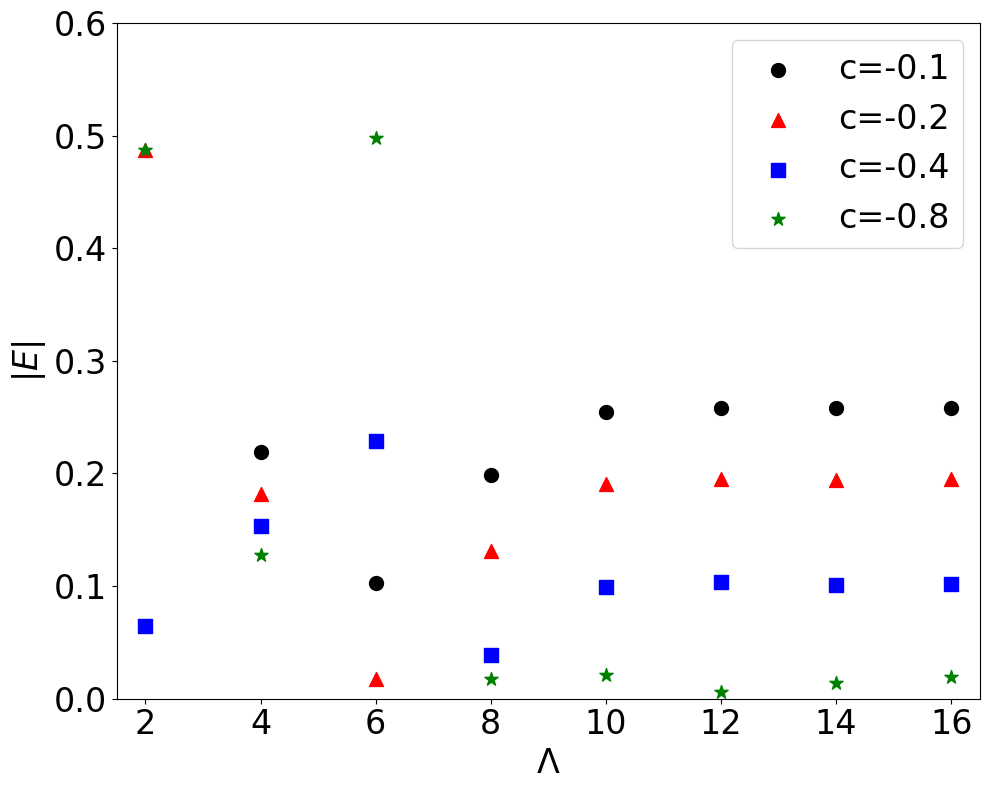

In [8]:
import matplotlib.pyplot as plt

import matplotlib 
#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

fig, ax = plt.subplots()

plt.scatter([x for x in range(2,18,2)],[abs(en.real) for en in e0raw0p1], c='black', marker='o', label='c=-0.1')
plt.scatter([x for x in range(2,18,2)],[abs(en.real) for en in e0raw0p2], c='red', marker='^', label='c=-0.2')
plt.scatter([x for x in range(2,18,2)],[abs(en.real) for en in e0raw0p4], c='blue', marker='s', label='c=-0.4')
plt.scatter([x for x in range(2,18,2)],[abs(en.real) for en in e0raw0p8], c='green', marker='*', label='c=-0.8')

plt.xlabel('$\\Lambda$')
plt.ylabel('$|E|$')

plt.xlim(1.5,16.5)
plt.ylim(0,0.6)
#plt.yscale('log')


plt.legend(loc='upper right')

plt.savefig('Plots/WZ_2site_quad_allc_classical.pdf',bbox_inches='tight')

In [9]:
# try plotting this E vs C for a few lambda S
# think about c->-infty limit

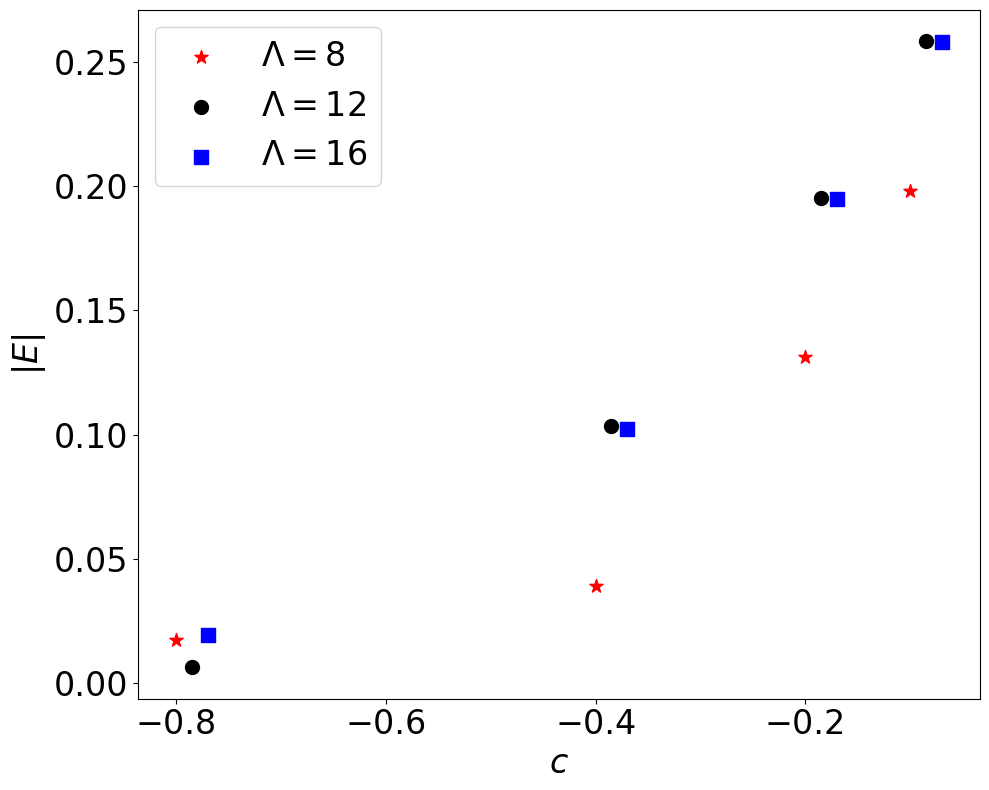

In [10]:
#lambdas={2:0,4:1,8:3,16:7}
lambdas={8:3, 12:5, 16:7}

ensVSc={}
for l,idx in lambdas.items():
    ensVSc[l]=[]
    ensVSc[l].append([-0.1,e0raw0p1[idx]])
    ensVSc[l].append([-0.2,e0raw0p2[idx]])
    ensVSc[l].append([-0.4,e0raw0p4[idx]])
    ensVSc[l].append([-0.8,e0raw0p8[idx]])
    ensVSc[l]=np.array(ensVSc[l])

offset=0
markers={8:'*', 12:'o', 16:'s'}
colors={8:'red', 12:'black', 16:'blue'}
for l in ensVSc:
    plt.scatter(ensVSc[l][:,0]+offset,np.abs(ensVSc[l][:,1]), label='$\\Lambda={}$'.format(l), marker=markers[l], color=colors[l])
    offset+=0.015
plt.legend(loc='upper left')
plt.xlabel('$c$')
plt.ylabel('$|E|$')

plt.savefig('Plots/WZ_2site_quad_allc_classical_funcC.pdf',bbox_inches='tight')



## BETTER VQE

In [ ]:
for cutoff in [2,4,8]:
    print("Lambda={}  |  N={}  |  c={}".format(cutoff, N, c))
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]

    opFileName="Data/op_quad_{}_lambda{}.pickle".format(cFileString,cutoff)

    op=None
    if os.path.isfile(opFileName):
        print("reading op file")
        with open(opFileName, "rb") as f:
            op = pickle.load(f)

    else:
        print("computing op")
        ps=matrix_to_pauli_strings(hamMat,standard_encode)
        op = pauli_string_to_op(ps)

        with open(opFileName, "wb") as f:
            pickle.dump(op, f)


    nq=math.floor(math.log2(hamMat.shape[0]))
    if not math.log2(hamMat.shape[0]).is_integer():
        nq+=1

    ansatz = RealAmplitudes(nq, reps=cutoff)

        
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
    results=[]
    for i in range(vqeShots):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)

    print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))

    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))